# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price — цена (евро)

## Подготовка данных

###  Импорт библиотек

In [1]:
# Обработка данных
import pandas as pd
import numpy as np

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.tree import DecisionTreeRegressor

In [2]:
pd.set_option('display.max_columns', None)

### Знакомство с данными

In [3]:
data = pd.read_csv('/datasets/autos.csv')

data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Обработка данных

In [5]:
shape_old = data.shape[0]
print('Количество данных до переработки:', shape_old)

Количество данных до переработки: 354369


#### Проверим наши данные на дубликаты

In [6]:
data.duplicated().sum()

4

4 дубликата не критично, удалим их.

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

data.duplicated().sum()

0

#### Работа с пропущенными значениями

In [8]:
def isna_view (df):
    return  (
                (df.isna().mean()*100)
                .sort_values(ascending=False)
                .to_frame()
                .rename(columns = {0:'percent_space'})
                .style.background_gradient('coolwarm').format("{:.1f}")
            )

isna_view (data)

,percent_space
Repaired,20.1
VehicleType,10.6
FuelType,9.3
Gearbox,5.6
Model,5.6
DateCrawled,0.0
Price,0.0
RegistrationYear,0.0
Power,0.0
Kilometer,0.0


В `Repaired` заменим значения на "unknown" т.к у нас нет такой информации была ли машина в ремонте или нет. В `Gearbox`,`VehicleType`,`Model` заменим значения на "other" т.к. тип кузова и модель сложно будет определить, а коробка передач может робот. В `FuelType` заменим на "petrol" самый популярный тип. 

In [9]:
data['Repaired'].fillna('unknown', inplace = True)
data['Gearbox'].fillna('other', inplace = True) 
data['FuelType'].fillna('petrol', inplace = True)
data['VehicleType'].fillna('other', inplace = True)
data['Model'].fillna('other', inplace = True)

In [10]:
isna_view (data)

,percent_space
DateCrawled,0.0
Price,0.0
VehicleType,0.0
RegistrationYear,0.0
Gearbox,0.0
Power,0.0
Model,0.0
Kilometer,0.0
RegistrationMonth,0.0
FuelType,0.0


#### Посмотрим на категориальные признаки

**Создадим функцию для построения графиков**

In [11]:
def graph_value_count(columns):
    fig, ax = plt.subplots(figsize=(14, 9))
    plt.style.use('seaborn-darkgrid')
    data[columns].value_counts(ascending = True).plot.barh(legend=False, fontsize=14);
    title_list = {'Brand': 'Бренд', 'VehicleType':'Тип кузова', 'FuelType':'Тип топлива', 
                  'RegistrationMonth':'Месяц регистрации', 'Gearbox':'Коробка передач'}
    plt.title(title_list[columns], size=18)
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y(),
                 str(round((i.get_width()), 2)),
                 fontsize=12, fontweight='medium',
                 color='#866CE6')

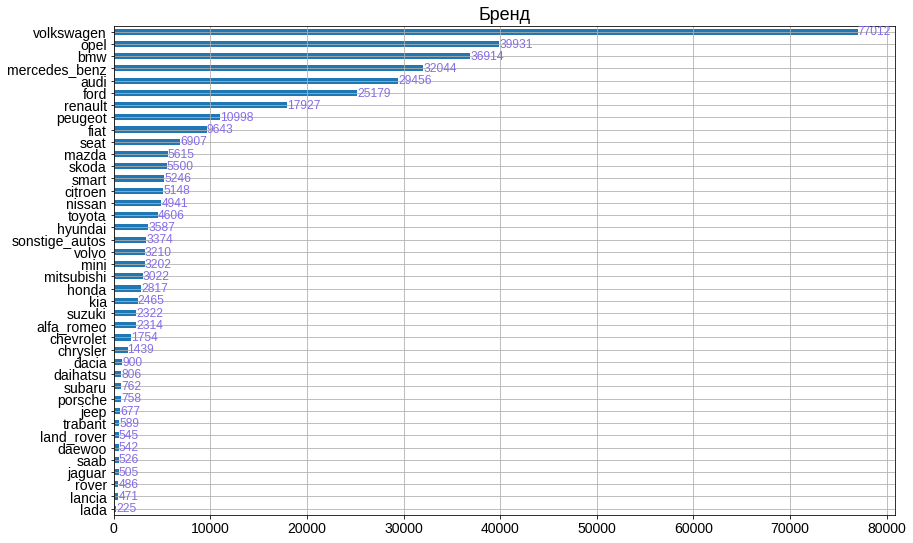

In [12]:
graph_value_count('Brand')

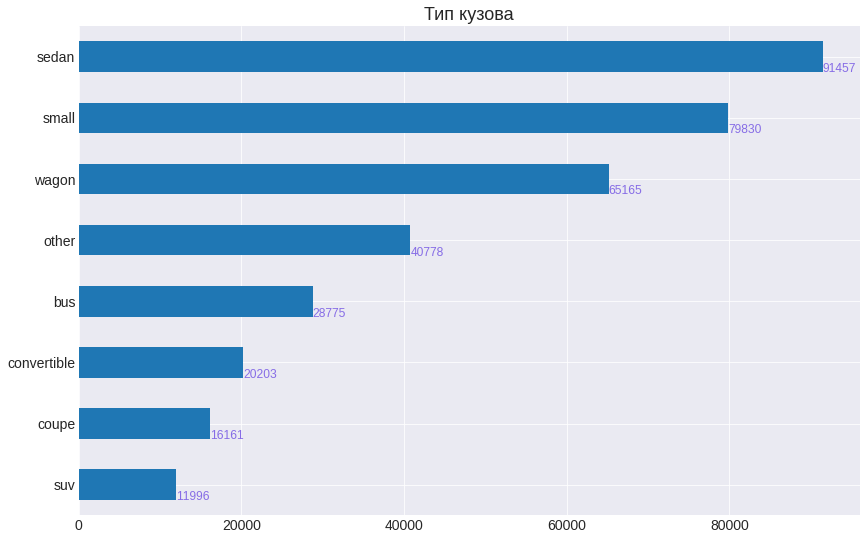

In [13]:
graph_value_count('VehicleType')

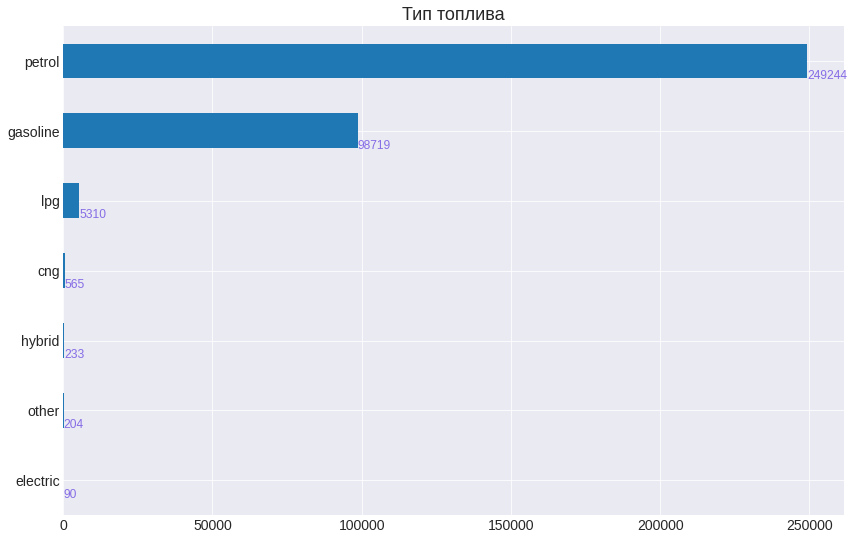

In [14]:
graph_value_count('FuelType')

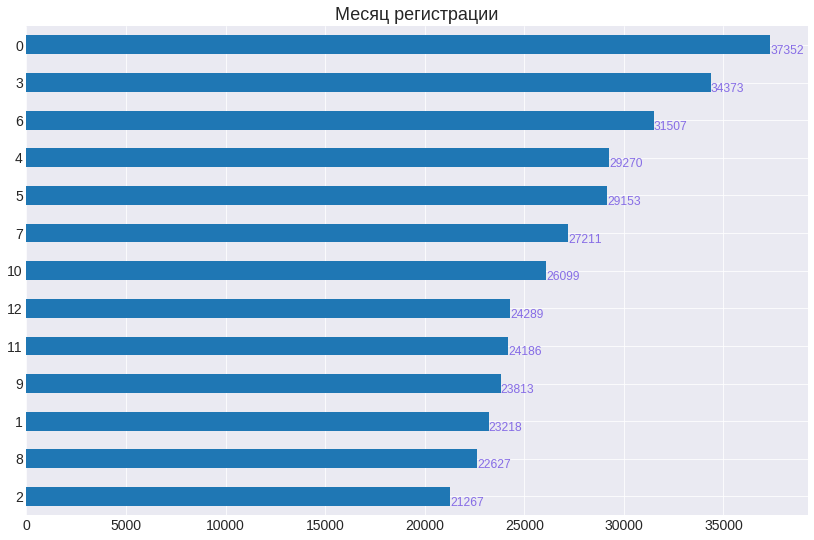

In [15]:
graph_value_count('RegistrationMonth')

* Избавимся от 0 скорей всего ошибка в приложение, т.к в большинстве приложений используется скроллинг, а не проставляется вручную.

In [16]:
data['RegistrationMonth'].count()

354365

In [17]:
data_regm =  data.loc[data['RegistrationMonth'] != 0, 'RegistrationMonth']
probs = np.bincount(data_regm)/data_regm.count()
res = np.random.choice(a = range(13), size = data.loc[data['RegistrationMonth'] ==0, 'RegistrationMonth'].count(), p = probs )
len(res)

37352

In [18]:
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = res
data['RegistrationMonth'].value_counts()

3     38423
6     35163
4     32737
5     32633
7     30431
10    29151
12    27209
11    26970
9     26637
1     25916
8     25282
2     23813
Name: RegistrationMonth, dtype: int64

In [19]:
data['RegistrationMonth'].count()

354365

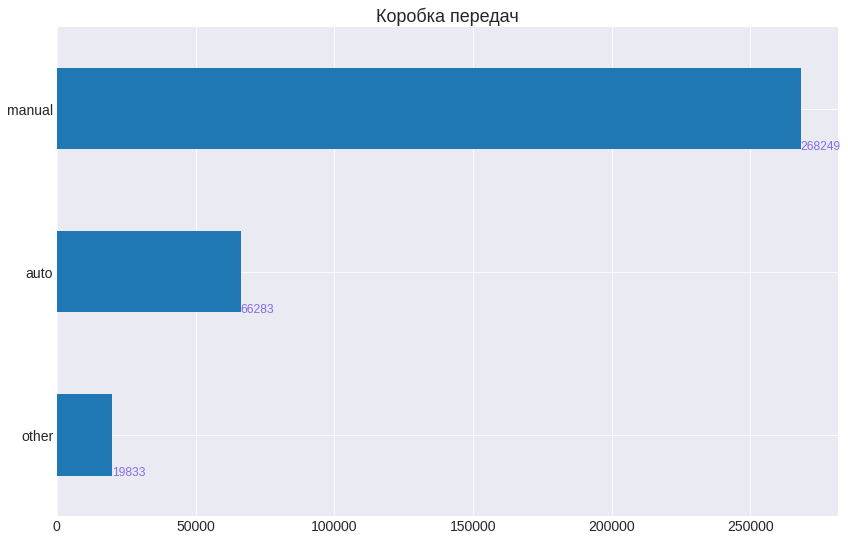

In [20]:
graph_value_count('Gearbox')

#### Построим графики для количественных признаков

**Создадим функцию для построения графиков**

In [21]:
def graph_hist_boxp(df, columns, bins, xlim_0, xlim_1):
    plt.figure(figsize=(12,6))
    plt.style.use('seaborn-darkgrid')
    
    df[columns].hist(bins=bins)
    plt.xlabel(columns)
    plt.xlim(xlim_0, xlim_1);
    plt.show()
    
    sns.boxplot(data=df, x=columns);
    plt.xlim(xlim_0, xlim_1);
    plt.show()

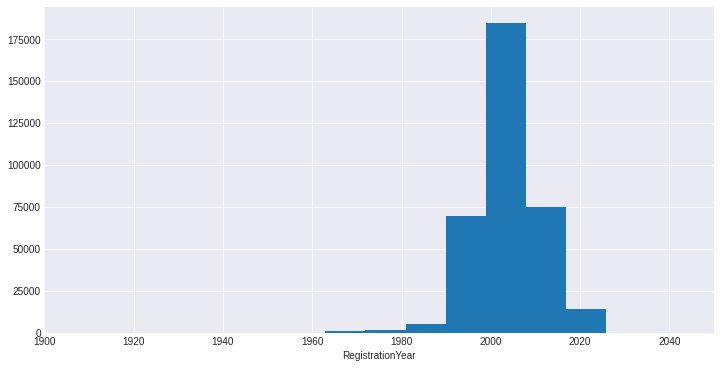

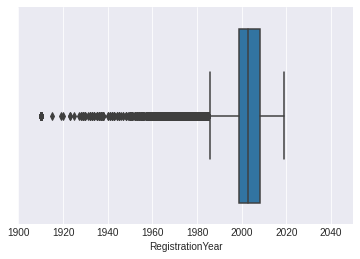

In [22]:
graph_hist_boxp(data, 'RegistrationYear', 1000, 1900, 2050)

Наблюдаться аномалии. Дата выпуска авто - 1910. Возможно, такой раритет еще остался, но для нас данные лучше подкорректировать и оставить авто хотя бы с 1940 года. Так же есть выбросы свыше 2017 года. Посмотрим на количество и удалим их.

In [23]:
data['DateCrawled'].sort_values(ascending = False)

90713     2016-04-07 14:36:58
339645    2016-04-07 14:36:56
301027    2016-04-07 14:36:55
53739     2016-04-07 14:36:54
204217    2016-04-07 14:36:53
                 ...         
324760    2016-03-05 14:06:24
176822    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
220582    2016-03-05 14:06:23
329493    2016-03-05 14:06:22
Name: DateCrawled, Length: 354365, dtype: object

In [24]:
data.loc[data['RegistrationYear'] > 2017].count().sum()

65424

In [25]:
data = data.loc[(data['RegistrationYear'] > 1940) & (data['RegistrationYear'] < 2017)]

In [26]:
data[['DateCrawled', 'DateCreated']]

,DateCrawled,DateCreated
0,2016-03-24 11:52:17,2016-03-24 00:00:00
1,2016-03-24 10:58:45,2016-03-24 00:00:00
2,2016-03-14 12:52:21,2016-03-14 00:00:00
3,2016-03-17 16:54:04,2016-03-17 00:00:00
4,2016-03-31 17:25:20,2016-03-31 00:00:00
...,...,...
354360,2016-03-21 09:50:58,2016-03-21 00:00:00
354361,2016-03-14 17:48:27,2016-03-14 00:00:00
354362,2016-03-05 19:56:21,2016-03-05 00:00:00
354363,2016-03-19 18:57:12,2016-03-19 00:00:00


**Взгляним на график цен на автомобиль**

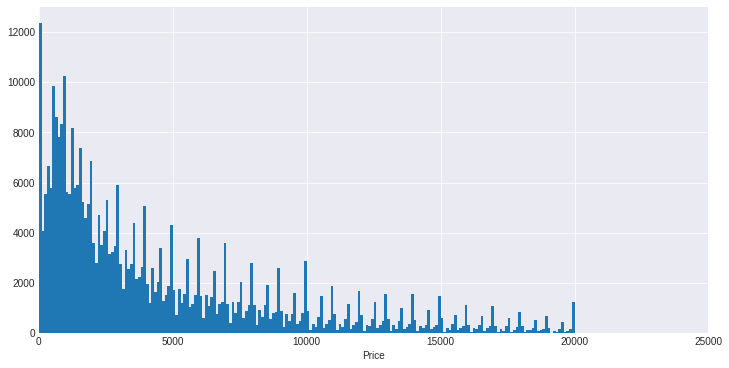

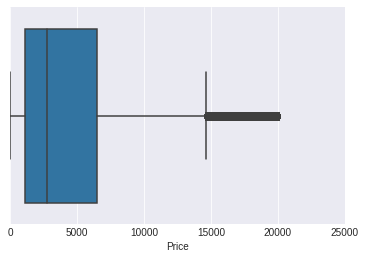

In [27]:
graph_hist_boxp(data, 'Price', 200, 0, 25000)

Цена авто - 0 евро, для нашего анализа будет мешать. Что стало причиной нулевого прайса, сложно сказать, но лучше избавиться от него.

In [28]:
data.loc[(data['Price'] > 19000)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
172,2016-03-07 12:38:19,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no,2016-03-07 00:00:00,0,38350,2016-03-12 20:18:29
484,2016-03-31 23:52:32,19900,bus,2009,manual,150,viano,90000,5,gasoline,mercedes_benz,no,2016-03-31 00:00:00,0,59348,2016-04-07 03:17:20
1360,2016-03-07 09:53:50,19850,sedan,2013,auto,150,golf,60000,6,gasoline,volkswagen,no,2016-03-07 00:00:00,0,57078,2016-03-20 16:48:15
1515,2016-03-09 10:18:36,20000,sedan,2010,auto,239,a6,150000,5,gasoline,audi,no,2016-03-07 00:00:00,0,56567,2016-03-30 19:17:04
1586,2016-04-03 21:41:49,20000,sedan,2014,auto,184,leon,40000,4,gasoline,seat,no,2016-04-03 00:00:00,0,30655,2016-04-05 22:18:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353189,2016-04-04 21:59:43,19500,bus,1970,auto,69,transporter,30000,11,petrol,volkswagen,unknown,2016-04-04 00:00:00,0,93354,2016-04-04 21:59:43
353586,2016-03-14 00:36:42,19950,wagon,2009,manual,265,other,125000,1,petrol,audi,no,2016-03-14 00:00:00,0,59872,2016-03-20 21:45:10
354041,2016-03-22 20:48:48,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no,2016-03-22 00:00:00,0,38118,2016-03-24 05:16:02
354174,2016-03-14 00:48:36,19990,small,2014,auto,185,a1,10000,2,petrol,audi,no,2016-03-13 00:00:00,0,42659,2016-04-07 03:17:51


In [29]:
data = data.loc[(data['Price'] != 0)]

**Посмотрим на график мощности автомобилей.**

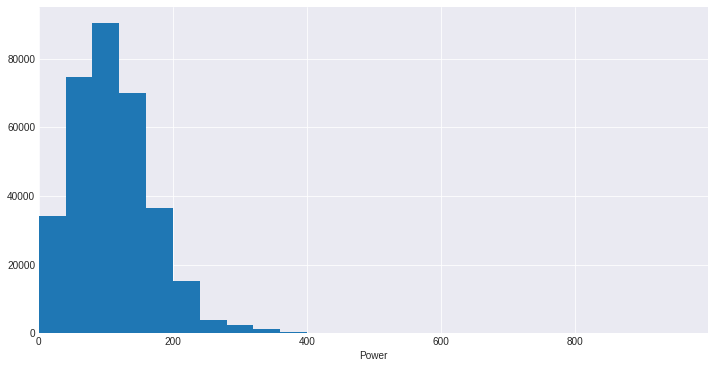

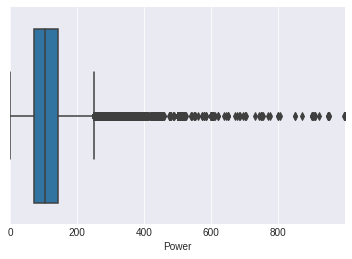

In [30]:
graph_hist_boxp(data, 'Power', 500, 0, 999)

Есть 0 мощность автомобиля. Предположим, что автомобиль без движка. По мощности свыше 250 л.с. идут выбросы. Учитывая, что в выборке у нас нет брендов автомобилей Ferrari, Bugatti Veyron, McLaren, то ограничимся до 400 л.с.

In [31]:
car_power0_400 = data[data['Power'] < 1] + data[data['Power'] > 400]

print(f'Процент автомобилей с мощность 0 и свыше 400 л.с. {(car_power0_400.shape[0] / data.shape[0] * 100):.2f}%')

Процент автомобилей с мощность 0 и свыше 400 л.с. 10.15%


Удалим аномалии в `Power`

In [32]:
data = data.loc[(data['Power'] < 400) & (data['Power'] != 0)]

**Посмотрим на график по километражу.**

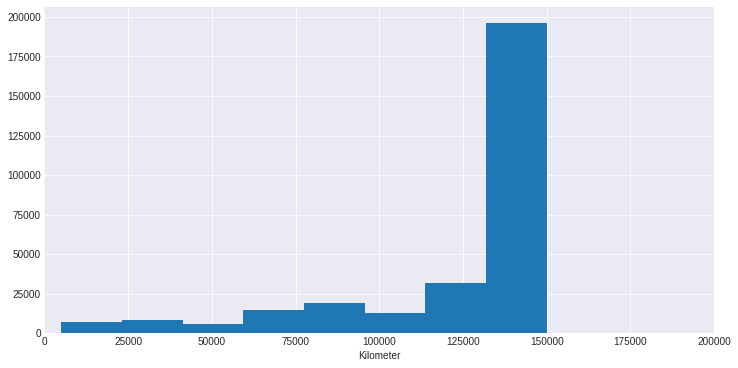

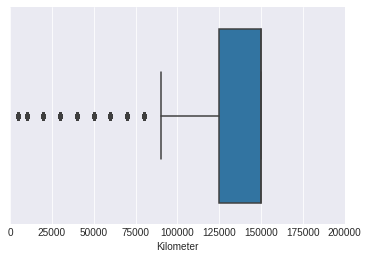

In [33]:
graph_hist_boxp(data, 'Kilometer', 8, 0, 200000)

Тут аномалий как таковых нет, но километраж уперается до 150 тыс.км возможно максимальное значение в приложение. 

#### Удалим ненужные нам признаки

In [34]:
data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [35]:
print('Процент потерянных данных {:.1%}'.format(1 - data.shape[0] / shape_old))

Процент потерянных данных 16.4%


**Итог по переработаке данных.**<a id='id1'></a>

И так у нас имеется датасет из 16 стобцов и 354369 записей. 
* Найдено 4 дубликата. Удалено.
* Пропуски в столбце `Repaired` - 20.1%. Заменены на **unknown**
* Пропуски в столбце `VehicleType` - 10.6%. Заменены на **other**
* Пропуски в столбце `FuelType` - 9.3%. Заменены на **petrol**
* Пропуски в столбце `Gearbox` - 5.6%. Заменены на **other** 
* Пропуски в столбце `Model` - 5.6%. Заменены на **other** 

**В категориальных признаках** 
* В столбце `RegistrationMonth` заполнили данные не меняя распределения в них.

**В количественных признаках** 
* В столбце `RegistrationYear` ограничились датами с 1940 по 2020.
* В столбце `Price` убрали 0 ценик и ограничились до 15000 евро. 
* В столбце `Power` огранисились мощностью до 400 л.с и убрали 0 мощность. 

**Удалили ненужные признаки**

`DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.

**Процент потерянных данных 16.4%**

In [36]:
!pip install phik

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01


In [37]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [38]:
phik_overview = data.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


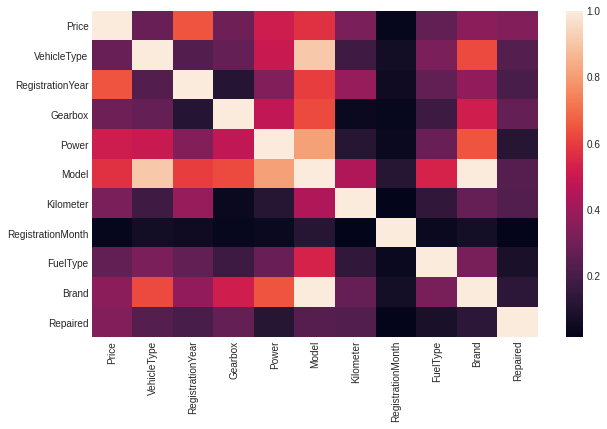

In [39]:
plt.figure(figsize = (10,6))
sns.heatmap(phik_overview);

In [40]:
phik_overview['Price'].sort_values(ascending = False)

Price                1.000000
RegistrationYear     0.649002
Model                0.573170
Power                0.511687
Brand                0.361340
Repaired             0.338364
Kilometer            0.320127
Gearbox              0.290430
VehicleType          0.277619
FuelType             0.263424
RegistrationMonth    0.027160
Name: Price, dtype: float64

Исходя из взаимосвязей наших данных, можем увидеть, что большие влияние на цену оказывает: Дата регистрации автомобиля, модель автомобиля, мощность и Бренд. 

## Обучение моделей

In [41]:
STATE = np.random.RandomState(12345)

Сохраним признаки в отдельные переменные.

In [42]:
target = data['Price']
features = data.drop('Price', axis = 1)

In [43]:
# Разобьем на обучающие и тестовую выборку.

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=STATE)

Получим категориальные и числовые имена столбцов.

In [44]:
num_features = features_train.select_dtypes(exclude=['object']).columns.tolist()
category_features = features_train.select_dtypes(include=['object']).columns.tolist()

In [45]:
print('Количество строк на обучающей выборке', features_train.shape[0])
print('Количество строк на тестовую выборку', features_test.shape[0])

Количество строк на обучающей выборке 222117
Количество строк на тестовую выборку 74040


### Обучим модель CatBoost

In [46]:
cat_model = CatBoostRegressor(verbose=False, cat_features= category_features,  
                              early_stopping_rounds=20)

parameters_cat = {'iterations':[50, 300],
                  'learning_rate':[0.3, 0.7],
                  'l2_leaf_reg':[3, 6]
                 }

model_cat = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_cat, 
                               scoring='neg_mean_squared_error', n_iter=5, cv = 3)

In [47]:
%%time

model_cat.fit(features_train, target_train)
print("Параметры:", model_cat.best_params_)
print('RMSE:', np.sqrt(-model_cat.best_score_))

Параметры: {'learning_rate': 0.3, 'l2_leaf_reg': 3, 'iterations': 300}
RMSE: 1604.7406910399916
CPU times: user 6min 36s, sys: 3.01 s, total: 6min 39s
Wall time: 6min 48s


In [48]:
grid_cat_res = pd.DataFrame(model_cat.cv_results_)
print(f'Время обучения модели: {grid_cat_res["mean_fit_time"].iloc[model_cat.best_index_]:.2f} сек.') 
print(f'Время предсказания: {grid_cat_res["mean_score_time"].iloc[model_cat.best_index_]:.2f} сек.')

Время обучения модели: 50.60 сек.
Время предсказания: 0.31 сек.


### Обучим модель LightGBM

In [64]:
light_model = LGBMRegressor(verbosity= -1, random_state = STATE, n_jobs=4)

parameters_light = {'num_leaves': [10, 30, 50, 60], 'max_depth': [5, 10, 20, 30], 
                    'learning_rate':[0.2, 0.5, 0.8]}

model_light = RandomizedSearchCV(estimator=light_model, param_distributions=parameters_light, scoring='neg_mean_squared_error',
                                         n_iter=4, cv = 3)

In [65]:
%%time

model_light.fit(features_train.astype({it:'category' for it in category_features}), target_train)
print("Параметры:", model_light.best_params_)
print('RMSE:', np.sqrt(-model_light.best_score_))

Параметры: {'num_leaves': 30, 'max_depth': 20, 'learning_rate': 0.2}
RMSE: 1590.1712522009816
CPU times: user 32.8 s, sys: 239 ms, total: 33.1 s
Wall time: 33.4 s


In [66]:
grid_light_res = pd.DataFrame(model_light.cv_results_)
print(f'Время обучения модели: {grid_light_res["mean_fit_time"].iloc[model_light.best_index_]:.2f} сек.') 
print(f'Время предсказания: {grid_light_res["mean_score_time"].iloc[model_light.best_index_]:.2f} сек.')

Время обучения модели: 1.93 сек.
Время предсказания: 0.61 сек.


### Обучим модель "Дерево решений"

In [52]:
ct = make_column_transformer((OneHotEncoder(sparse=False, handle_unknown='ignore'), 
                              category_features), 
                             (StandardScaler(), num_features), remainder='passthrough')

tree_model = Pipeline(steps=[('prep', ct), ('dtr', DecisionTreeRegressor())])

parametr_set = {'dtr__max_depth': [4, 6, 10], 
                'dtr__min_samples_split': [2, 3, 4], 
                'dtr__min_samples_leaf': [10, 20]}

model_tree = RandomizedSearchCV(estimator=tree_model, param_distributions=parametr_set, 
                               scoring='neg_mean_squared_error', n_iter=5, cv = 3)

In [53]:
%%time

model_tree.fit(features_train, target_train)
print("Параметры:", model_tree.best_params_)
print('RMSE:', np.sqrt(-model_tree.best_score_))

Параметры: {'dtr__min_samples_split': 4, 'dtr__min_samples_leaf': 10, 'dtr__max_depth': 10}
RMSE: 1977.4929661593965
CPU times: user 1min 29s, sys: 13.5 s, total: 1min 43s
Wall time: 1min 43s


In [54]:
grid_tree_res = pd.DataFrame(model_tree.cv_results_)
print(f'Время обучения модели: {grid_tree_res["mean_fit_time"].iloc[model_tree.best_index_]:.2f} сек.') 
print(f'Время предсказания: {grid_tree_res["mean_score_time"].iloc[model_tree.best_index_]:.2f} сек.')

Время обучения модели: 6.49 сек.
Время предсказания: 0.50 сек.


In [67]:
rmse = [np.sqrt(-model_cat.best_score_), np.sqrt(-model_light.best_score_), np.sqrt(-model_tree.best_score_)]
time_fit = [grid_cat_res["mean_fit_time"].iloc[model_cat.best_index_], 
            grid_light_res["mean_fit_time"].iloc[model_light.best_index_],
            grid_tree_res["mean_fit_time"].iloc[model_tree.best_index_]]
time_pred = [grid_cat_res["mean_score_time"].iloc[model_cat.best_index_],
             grid_light_res["mean_score_time"].iloc[model_light.best_index_],
             grid_tree_res["mean_score_time"].iloc[model_tree.best_index_]]

In [68]:
df_current_results = pd.DataFrame(data = [rmse, time_fit, time_pred],
                                 columns = ['CatBoost', 'LightGBM', 'Дерево решений'],
                                 index = ['RMSE', 'Время обучения', 'Время предсказания'])

In [69]:
df_current_results

,CatBoost,LightGBM,Дерево решений
RMSE,1604.740691,1590.171252,1977.492966
Время обучения,50.598430,1.933283,6.490482
Время предсказания,0.309204,0.607560,0.502648


**Итог:** \
Лучший результат *RMSE* у модели **"LightGBM"** с результатами *RMSE*: 1590.17. Время обучения 1.93 сек. Время предсказания 0.6 сек. 

На втором месте модель **"CatBoost"**  *RMSE* хуже 1604.74. Время обучения 50.59 Время предсказания 0.30 сек.

**Дерево решений** получилось *RMSE* 1977.49. Время обучения 6.49 сек, а Время предсказания 0.5

Для тестовой выборки будем использовать модель **LightGBM**.

## Анализ моделей

**Найдем важность признаков**

In [58]:
importances = model_light.best_estimator_.feature_importances_

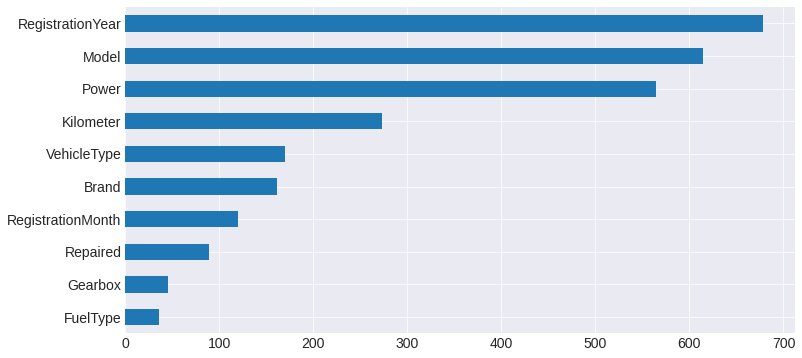

In [59]:
pd.Series(importances, index = features_train.columns).sort_values().plot.barh(legend=False, fontsize=14, figsize=(12, 6));

Проверим нашу модель на тестовой выборке.

In [60]:
%%time

predict_light = model_light.best_estimator_.predict(features_test.astype({it:'category' for it in category_features}))
mse = mean_squared_error(target_test, predict_light)
rmse = np.sqrt(mse)
rmse

CPU times: user 661 ms, sys: 0 ns, total: 661 ms
Wall time: 656 ms


1585.0382461703427

In [61]:
from sklearn.dummy import DummyRegressor

In [62]:
baseline_model = Pipeline(steps=[('prep', ct), ('dtr', DummyRegressor())])

baseline_model.fit(features_train, target_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth'])])),
                ('dtr', DummyRegressor())])

In [63]:
predicted_test = baseline_model.predict(features_test)
mse = mean_squared_error(target_test, predicted_test)
print("RMSE:", np.sqrt(mse))

RMSE: 4583.183571257432


Наша модель показывает хороший результат т.к на константной RMSE выше.

**Вывод:** Задачей нашего проекта было для сервиса по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Необходимо было постройте модель, которая умеет её определять. В нашем распоряжениие данные о технических характеристиках, комплектации и ценах других автомобилей.

**Критерии, которые важны заказчику:**
Качество предсказания;
Время обучения модели;
Время предсказания модели.

Мы сделали [переработку данных.](#id1) и обучили 3 модели.

1-я модель **CatBoost** получили следующие результаты: RMSE: 1604.74, время обучения 50.59 сек. Время предсказания 0.3 сек

2-я модель **LightGBM** получили следующие результаты: RMSE: 1590.17, время обучения 1.93 сек. Время предсказания 0.6 сек

3-я модель **Дерево решений** получили следующие результаты: RMSE: 1977.49, время обучения 6.49 сек. Время предсказания 0.5 сек

Для дальнейшего анализа мы выбрали модель **LightGBM** и определили важность признаков.
1. Самый важный признак `RegistrationYear` — год регистрации автомобиля
2. На втором месте `Model` — модель автомобиля
3. На третьем месте `Power` — мощность (л. с.)
4. На четвертом месте, который тоже можно выделить `Kilometer` — пробег (км).

На тестовой выборке мы также получили хороший результат RMSE: 1551.74.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей